### DESARROLLO MODELO HÍBRIDO PARA PREDECIR COEFICIENTE DE ACTIVIDAD 

### Cargar los datos ya limpiados y analizados en el Notebook analisis data y cargar librerias necesarias

In [4]:
!pip install -q -U keras-tuner

In [1]:
import numpy as np
import pandas as pd
from keras import backend as K
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_percentage_error
import matplotlib.pyplot as plt
datos=pd.read_csv("Datos_Modelo_hibrido1.csv")



### Preprocesamiento de datos

In [2]:

variables_categoricas = ["Cation", "Anion"]
variables_numericas = ["Solute_Mol_Mass", "Num_Cations", "Num_Anions", "Molal","Molal_Activity_Coefficient_Wilson"]
variables_a_predecir = ["Molal_Activity_Coefficient_exp"]
column_transformer = ColumnTransformer(
    transformers=[
        ("cat", OneHotEncoder(), variables_categoricas),
        ("num", StandardScaler(), variables_numericas)
    ])

X = column_transformer.fit_transform(datos[variables_categoricas + variables_numericas])



In [3]:

from sklearn.model_selection import train_test_split
train_data, test_data = train_test_split(datos, test_size=0.2, random_state=75, stratify=datos['Id_solucion'])
X_test = column_transformer.transform(test_data[variables_categoricas + variables_numericas])
y_test = test_data[variables_a_predecir].values
X_train = column_transformer.transform(train_data[variables_categoricas + variables_numericas])
y_train = train_data[variables_a_predecir].values
X_train=X_train.toarray()


### CREACION MODELO XGBOOSTER


In [4]:
import xgboost as xgb


dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

params = {
    'max_depth': 10,
    'eta': 0.005,
    'objective': 'reg:tweedie',
    'eval_metric': 'rmse',
    'min_child_weight': 1,
    'subsample': 0.3,
    'colsample_bytree': 0.9,
    'seed': 42,
    'lambda': 0, # regularización L2
    'alpha': 0.06, # regularización L1
    'gamma': 0 # regularización L1
}


model = xgb.train(params=params, dtrain=dtrain, num_boost_round=1700, early_stopping_rounds=10, evals=[(dtest, 'test')],verbose_eval=False)

y_pred = model.predict(dtest)


print('R2 Score:', r2_score(y_test[:, 0], y_pred))
print('RMSE:', np.sqrt(mean_squared_error(y_test[:, 0], y_pred)))
print('MAPE:', mean_absolute_percentage_error(y_test[:, 0], y_pred))

R2 Score: 0.9974734038117857
RMSE: 0.017688174828036144
MAPE: 0.01861189463483638


In [9]:
feature_importances_gini = model.get_score(importance_type='gain')
print(feature_importances_gini)

{'f0': 0.0021157418377697468, 'f1': 0.0074861785396933556, 'f2': 0.06593188643455505, 'f3': 0.02062692493200302, 'f4': 0.021225592121481895, 'f5': 0.0012986618094146252, 'f6': 0.019700003787875175, 'f7': 0.0038401244673877954, 'f8': 0.014534180983901024, 'f9': 0.15935799479484558, 'f10': 0.0012385164154693484, 'f11': 0.011672808788716793, 'f12': 0.07796254754066467, 'f13': 0.11215031147003174, 'f14': 0.03044021502137184, 'f15': 0.019839461892843246, 'f16': 0.022184817120432854, 'f17': 0.018507426604628563, 'f18': 0.021911177784204483, 'f19': 0.027986934408545494, 'f20': 0.009448069147765636, 'f21': 0.011557639576494694, 'f22': 0.015581219457089901, 'f23': 0.004080670885741711, 'f24': 0.007013007998466492, 'f25': 0.046828411519527435, 'f26': 0.43586474657058716}


In [12]:
importance = model.get_score(importance_type='gain')

# Obtener las características y su importancia
features = list(importance.keys())
values = list(importance.values())

# Sumar los primeros 11 valores de importancia
Cation = sum(values[:11])

# Sumar los siguientes 11 valores de importancia
Anion = sum(values[11:22])

print("Suma de los primeros 11 valores de importancia: ", Cation)
print("Suma de los siguientes 11 valores de importancia: ", Anion)

Suma de los primeros 11 valores de importancia:  0.3173558061243966
Suma de los siguientes 11 valores de importancia:  0.3636614093557


In [ ]:
# Asumiendo que ya tienes las importancias calculadas en `feature_importances_gini` y `feature_importances_permutation`

# Ajustar el OneHotEncoder por separado para obtener las categorías
o = OneHotEncoder().fit(train_data[variables_categoricas])
categorias_codificadas = o.categories_

# Calcular la cantidad de características codificadas para cada variable categórica
num_caracteristicas_categoricas = [len(cat) for cat in categorias_codificadas]
total_caracteristicas_categoricas = sum(num_caracteristicas_categoricas)

# Calcular la importancia de las variables categóricas
suma_importancia_gini = []
suma_importancia_permutacion = []
inicio = 0

for num_car in num_caracteristicas_categoricas:
    fin = inicio + num_car
    suma_importancia_gini.append(np.sum(feature_importances_gini[inicio:fin]))
    suma_importancia_permutacion.append(np.sum(feature_importances_permutation[inicio:fin]))
    inicio = fin

# Imprimir la suma de importancia de las variables categóricas
print("Suma de la importancia de las variables categóricas utilizando la importancia de Gini:")
print(suma_importancia_gini)

print("\nSuma de la importancia de las variables categóricas utilizando el método de permutación:")
print(suma_importancia_permutacion)

### Graficos de dispersion

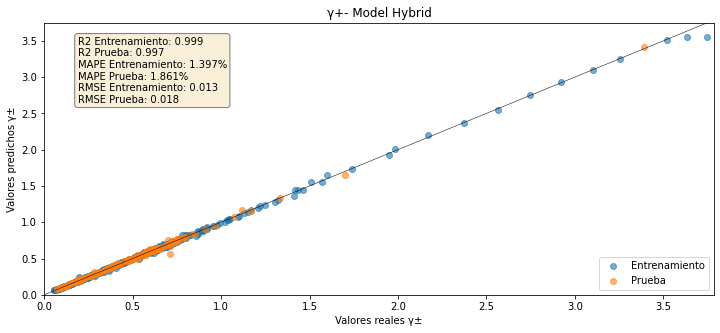

In [15]:
import numpy as np
from sklearn.metrics import r2_score, mean_squared_error,mean_absolute_percentage_error
import matplotlib.pyplot as plt
y_train_pred = model.predict(dtrain)
y_test_pred = model.predict(dtest)
metrics_train = []
metrics_test = []


r2_train = r2_score(y_train, y_train_pred)
mape_train = mean_absolute_percentage_error(y_train, y_train_pred)*100
mse_train = np.sqrt(mean_squared_error(y_train, y_train_pred))
    
r2_test = r2_score(y_test, y_test_pred)
mape_test = mean_absolute_percentage_error(y_test, y_test_pred)*100
mse_test = np.sqrt(mean_squared_error(y_test, y_test_pred))
    
metrics_train.append((r2_train, mape_train, mse_train))
metrics_test.append((r2_test, mape_test, mse_test))

fig, ax = plt.subplots(1, 1, figsize=(12, 5))
x = np.linspace(0, y_train.max()+0.04, 100)
ax.plot(x, x, color='black', linestyle='-', linewidth=0.5)
ax.scatter(y_train[:, 0], y_train_pred, alpha=0.6, label="Entrenamiento")
ax.scatter(y_test[:, 0], y_test_pred, alpha=0.6, label="Prueba")
ax.set_xlim(0, max(y_train.max(), y_train.max())+0.04)
ax.set_ylim(0, max(y_train.max(), y_train.max()))
ax.set_xlabel("Valores reales γ±")
ax.set_ylabel("Valores predichos γ±")
ax.set_title("γ+-" +" Model Hybrid")

metrics_text = f"R2 Entrenamiento: {metrics_train[0][0]:.3f}\nR2 Prueba: {metrics_test[0][0]:.3f}\nMAPE Entrenamiento: {metrics_train[0][1]:.3f}%\nMAPE Prueba: {metrics_test[0][1]:.3f}%\nRMSE Entrenamiento: {metrics_train[0][2]:.3f}\nRMSE Prueba: {metrics_test[0][2]:.3f}" 
ax.text(0.05, 0.95, metrics_text, transform=ax.transAxes, verticalalignment='top', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

ax.legend(loc='lower right')
plt.savefig("ANN-MLP.jpg")
plt.show()

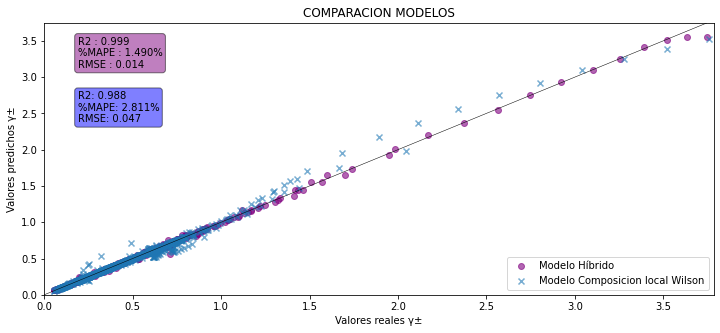

In [18]:
import numpy as np
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_percentage_error
import matplotlib.pyplot as plt
y_exp= datos["Molal_Activity_Coefficient_Wilson"]
y_model=datos["Molal_Activity_Coefficient_exp"]
y_train_pred = model.predict(dtrain)
y_test_pred = model.predict(dtest)

metrics_total = []
metrics= []
y_total = np.concatenate((y_train, y_test), axis=0)
y_pred_total = np.concatenate((y_train_pred, y_test_pred), axis=0)

r2_total = r2_score(y_total, y_pred_total)
mape_total = mean_absolute_percentage_error(y_total, y_pred_total) * 100
mse_total = np.sqrt(mean_squared_error(y_total, y_pred_total))

metrics_total.append((r2_total, mape_total, mse_total))
r2 = r2_score(y_exp, y_model)
mape= mean_absolute_percentage_error(y_exp, y_model)*100
mse = np.sqrt(mean_squared_error(y_exp, y_model))
    

metrics.append((r2, mape, mse))

fig, ax = plt.subplots(1, 1, figsize=(12, 5))
x = np.linspace(0, y_total.max(), 100)
ax.plot(x, x, color='black', linestyle='-', linewidth=0.5)
ax.scatter(y_total[:, 0], y_pred_total, alpha=0.6, label="Modelo Híbrido", color="purple")
ax.scatter(y_exp, y_model, alpha=0.6, label="Modelo Composicion local Wilson", marker='x')

ax.set_xlabel("Valores reales γ±")
ax.set_ylabel("Valores predichos γ±")
ax.set_title("COMPARACION MODELOS")
ax.set_xlim(0, max(y_train.max(), y_train.max())+0.04)
ax.set_ylim(0, max(y_train.max(), y_train.max()))
metrics_text = f"R2 : {metrics_total[0][0]:.3f}\n%MAPE : {metrics_total[0][1]:.3f}%\nRMSE : {metrics_total[0][2]:.3f}"
ax.text(
    0.05,
    0.95,
    metrics_text,
    transform=ax.transAxes,
    verticalalignment='top',
    bbox=dict(boxstyle='round', facecolor='purple', alpha=0.5)
)
metrics_text = f"R2: {metrics[0][0]:.3f}\n%MAPE: {metrics[0][1]:.3f}%\nRMSE: {metrics[0][2]:.3f}" 
ax.text(0.05, 0.75, metrics_text, transform=ax.transAxes, verticalalignment='top', bbox=dict(boxstyle='round', facecolor='blue', alpha=0.5))
ax.legend(loc='lower right')
plt.savefig("ANN-MLP.jpg")
plt.show()

### Histogramas de de las desviaciones porcentuales

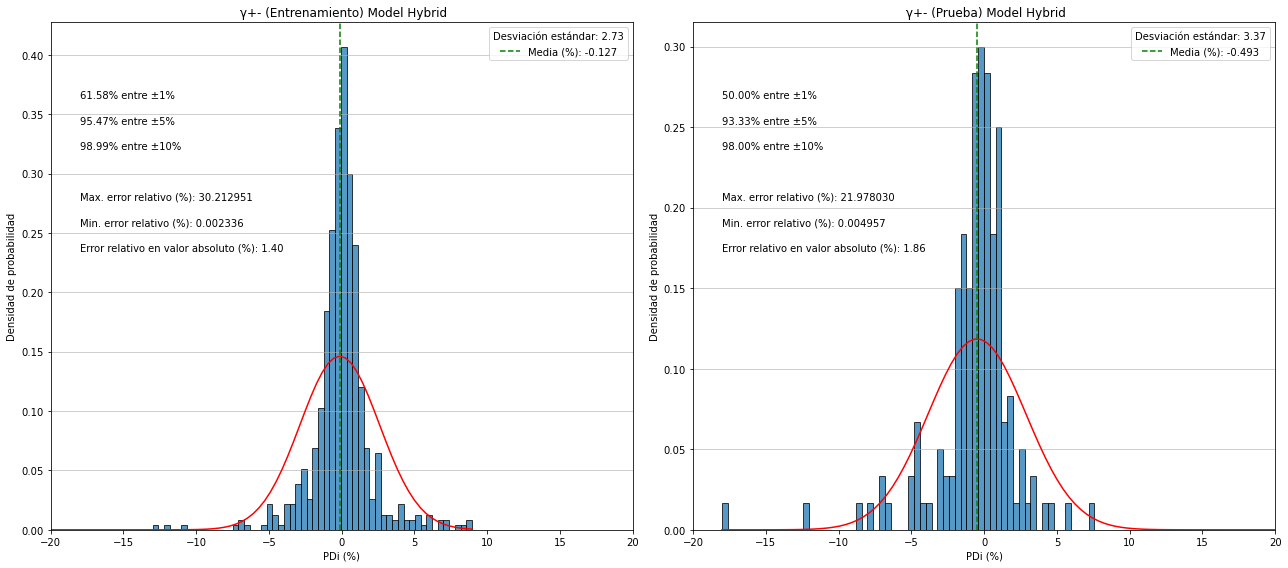

In [33]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats


train_pred = y_train_pred
test_pred = y_test_pred

def plot_relative_errors_histogram(ax, y_true, y_pred, title, xlim):
    errors = (((y_true - y_pred) / y_true) * 100).ravel()

    bins = np.linspace(errors.min(), errors.max(), 100)
    density, _, _ = ax.hist(errors, bins=100, density=True, ec='black', alpha=0.75)

    mean = errors.mean()
    std = errors.std()
    max_error = np.abs(errors).max()
    min_error = np.abs(errors).min()
    abs_error = np.abs(errors).mean()

    normal_dist = stats.norm.pdf(bins, mean, std)
    ax.plot(bins, normal_dist, color='r')

    # Calcular porcentajes
    perc_1 = np.sum((errors >= -1) & (errors <= 1)) / len(errors) * 100
    perc_5 = np.sum((errors >= -5) & (errors <= 5)) / len(errors) * 100
    perc_10 = np.sum((errors >= -10) & (errors <= 10)) / len(errors) * 100

    ax.axvline(mean, color='g', linestyle='--', label=f'Media (%): {mean:.3f}')
    ax.legend(title=f'Desviación estándar: {std:.2f}')

    ax.set_title(title)
    ax.set_xlabel('PDi (%)')
    ax.set_ylabel('Densidad de probabilidad')
    ax.grid(axis='y', alpha=0.75)
    ax.set_xlim(xlim)

    # Agregar porcentajes al gráfico
    ax.annotate(f'{perc_1:.2f}% entre ±1%', xy=(0.05, 0.85), xycoords='axes fraction', fontsize=10, color='black')
    ax.annotate(f'{perc_5:.2f}% entre ±5%', xy=(0.05, 0.80), xycoords='axes fraction', fontsize=10, color='black')
    ax.annotate(f'{perc_10:.2f}% entre ±10%', xy=(0.05, 0.75), xycoords='axes fraction', fontsize=10, color='black')

    # Agregar métricas al gráfico
    ax.annotate(f'Max. error relativo (%): {max_error:.6f}', xy=(0.05, 0.65), xycoords='axes fraction', fontsize=10, color='black')
    ax.annotate(f'Min. error relativo (%): {min_error:.6f}', xy=(0.05, 0.60), xycoords='axes fraction', fontsize=10, color='black')
    ax.annotate(f'Error relativo en valor absoluto (%): {abs_error:.2f}', xy=(0.05, 0.55), xycoords='axes fraction', fontsize=10, color='black')

fig, axes = plt.subplots(1, 2, figsize=(18, 8))

# Límites para los gráficos de las dos primeras variables de salida
limits = [(-20, 20)]


plot_relative_errors_histogram(axes[0], y_train[:, 0], train_pred, f' γ+- (Entrenamiento) Model Hybrid', limits[0])
plot_relative_errors_histogram(axes[1], y_test[:, 0], test_pred, f' γ+- (Prueba) Model Hybrid', limits[0])
       
plt.tight_layout()
plt.savefig("ANN-MLP.jpg")
plt.show()


### Validacion cruzada del modelo Hibrído.

In [40]:
import xgboost as xgb
from sklearn.model_selection import cross_val_score

# Definir el conjunto de entrenamiento y el conjunto de prueba
dtrain = xgb.DMatrix(X_train, label=y_train)

# Definir los hiperparámetros del modelo de XGBoost
params = {
    'max_depth': 10,
    'eta': 0.005,
    'objective': 'reg:tweedie',
    'eval_metric': 'rmse',
    'min_child_weight': 1,
    'subsample': 0.3,
    'colsample_bytree': 0.9,
    'seed': 42,
    'lambda': 0, # regularización L2
    'alpha': 0.06, # regularización L1
    'gamma': 0 # regularización L1
}

# Realizar la validación cruzada
cv_results = xgb.cv(params=params, dtrain=dtrain, num_boost_round=2000, nfold=5, early_stopping_rounds=10, metrics='mape', seed=42, verbose_eval=False)

# Imprimir la media del MAPE y su desviación estándar
print('MAPE mean:', cv_results['test-mape-mean'].iloc[-1])
print('MAPE std:', cv_results['test-mape-std'].iloc[-1])

MAPE mean: 0.021698803284348395
MAPE std: 0.003316860138689567


### Grafico por solucion individual

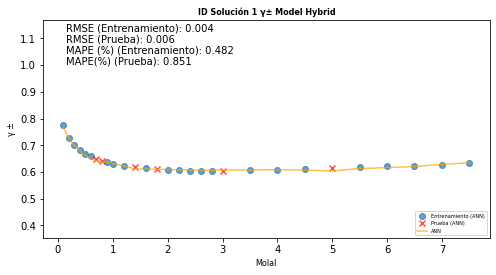

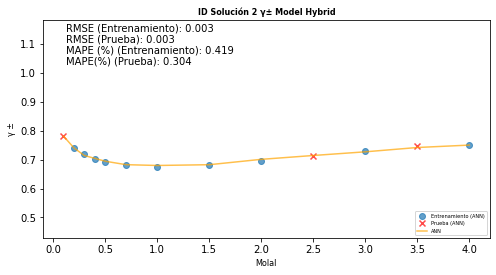

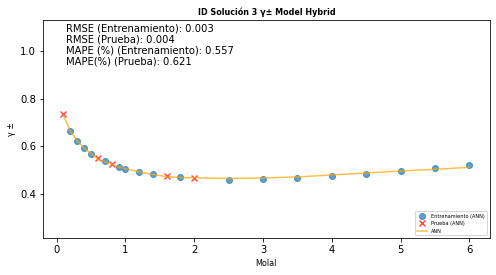

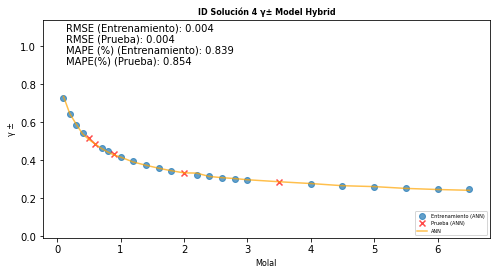

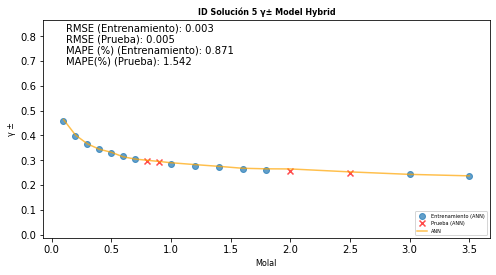

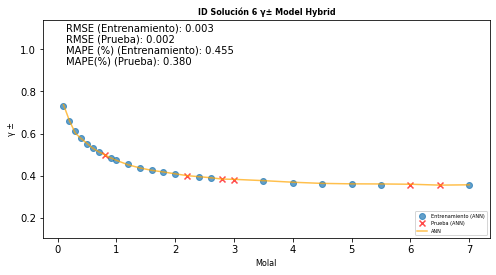

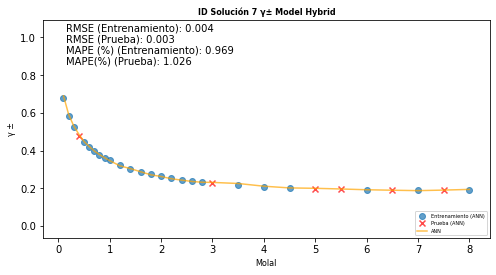

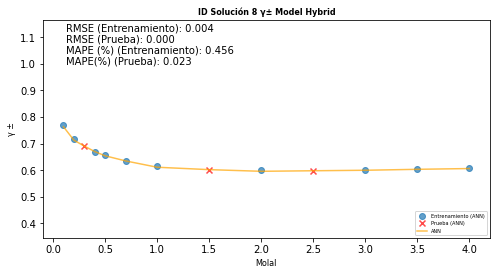

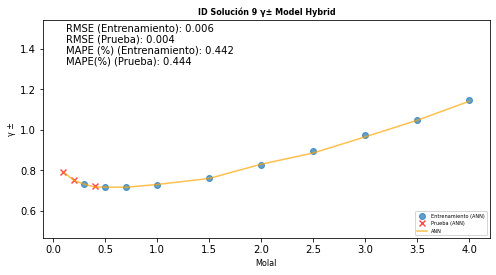

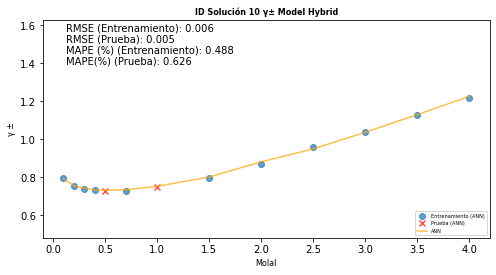

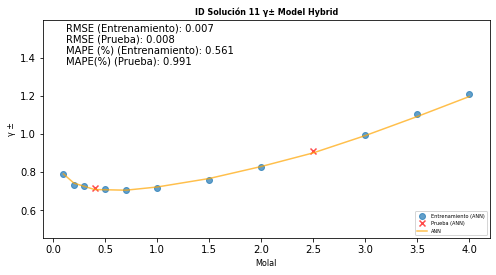

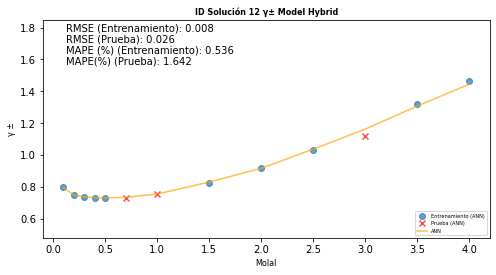

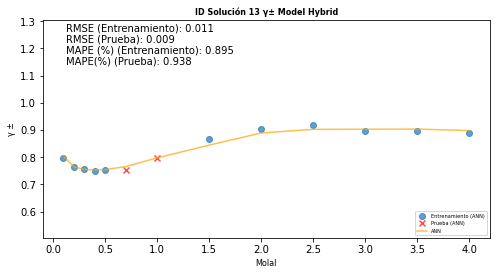

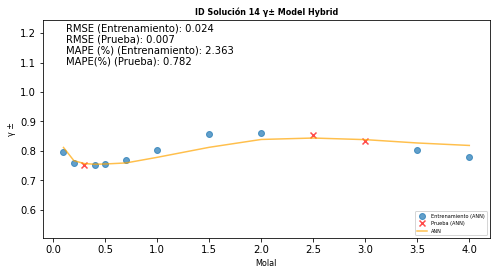

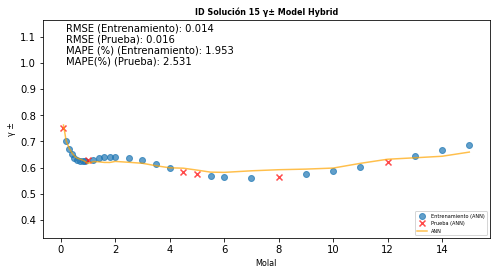

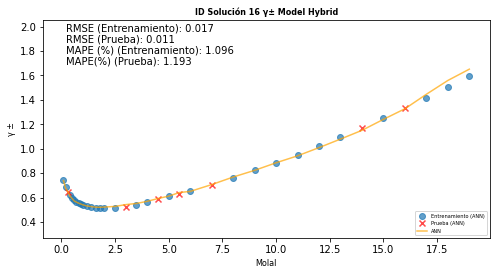

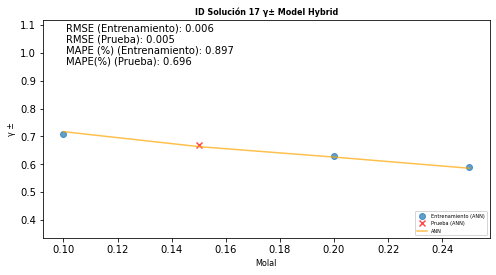

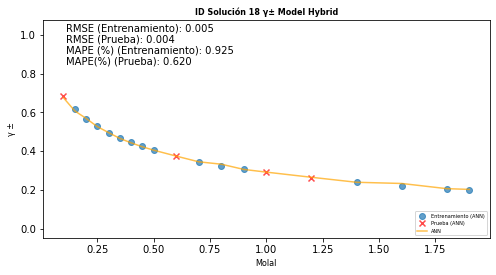

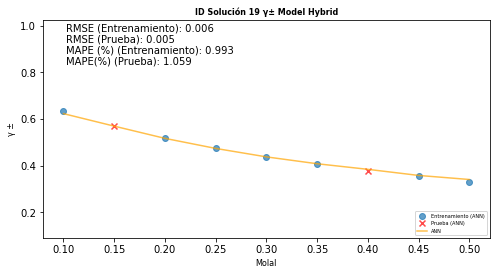

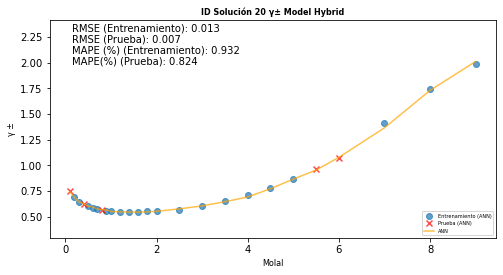

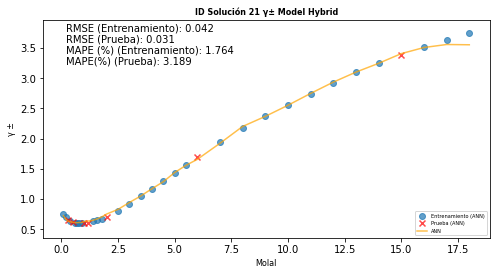

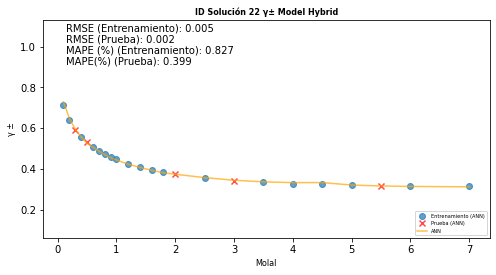

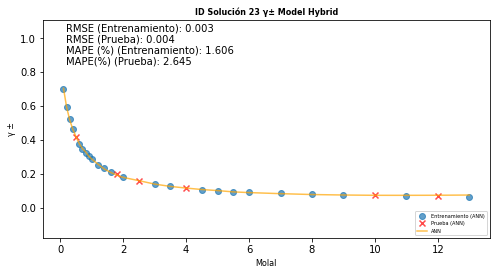

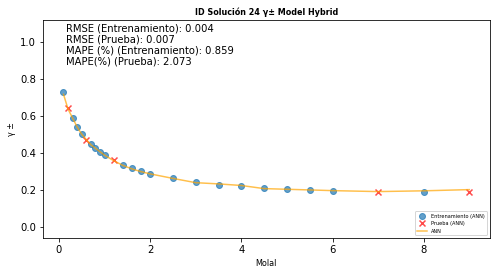

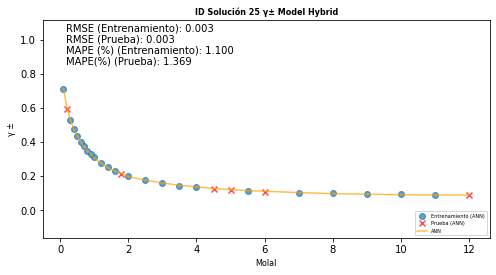

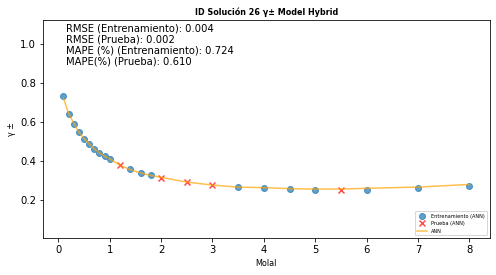

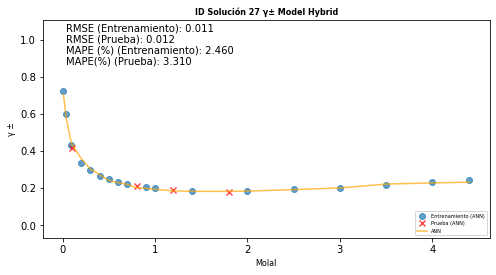

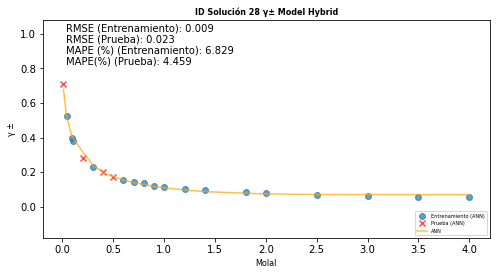

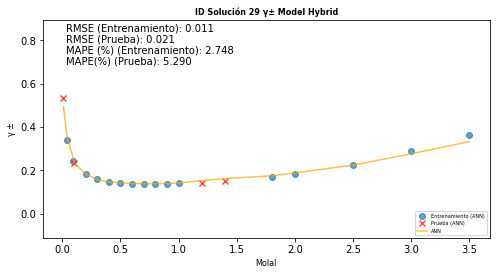

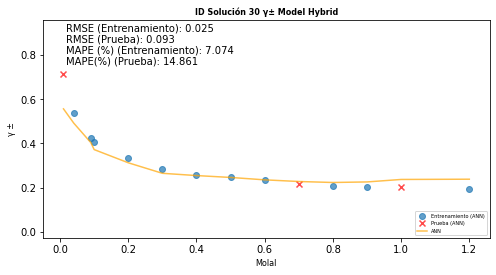

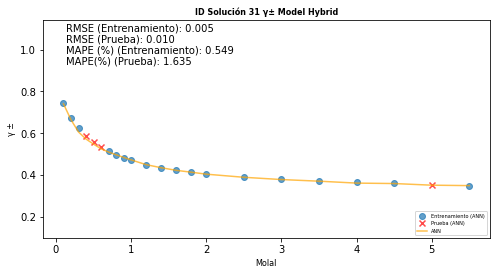

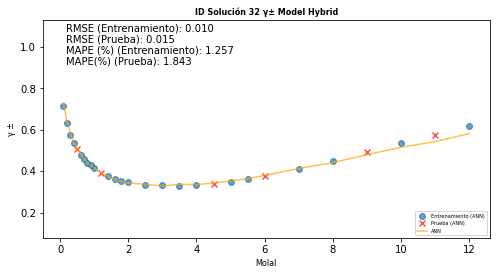

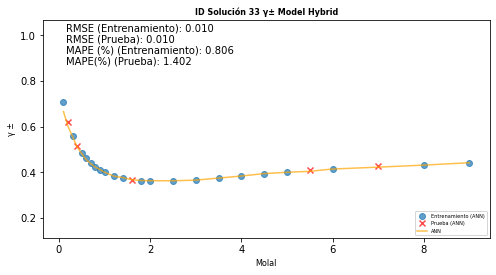

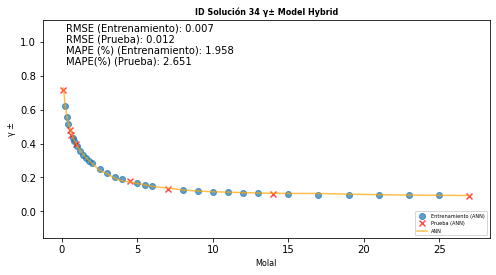

In [7]:
from sklearn.model_selection import train_test_split
from matplotlib.backends.backend_pdf import PdfPages
from sklearn.metrics import mean_squared_error, r2_score,mean_absolute_percentage_error
#def mean_absolute_percentage_error(y_true, y_pred):
    #return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

predictions_df = pd.DataFrame()
with PdfPages('todas_las_graficas.pdf') as pdf:
    for id_solucion in range(1, 35):
        train_solucion = train_data[train_data["Id_solucion"] == id_solucion]
        test_solucion = test_data[test_data["Id_solucion"] == id_solucion]

        X_train_solucion = column_transformer.transform(train_solucion[variables_categoricas + variables_numericas])
        X_test_solucion = column_transformer.transform(test_solucion[variables_categoricas + variables_numericas])
        X_train_solucion=X_train_solucion.toarray()
        X_test_solucion=X_test_solucion.toarray()
        y_train_solucion = train_solucion["Molal_Activity_Coefficient_exp"].values
        y_test_solucion = test_solucion["Molal_Activity_Coefficient_exp"].values


        dtrain = xgb.DMatrix(X_train_solucion, label=y_train_solucion)
        dtest = xgb.DMatrix(X_test_solucion, label=y_test_solucion)

        y_train_solucion_pred = model.predict(dtrain)
        y_test_solucion_pred = model.predict(dtest)

        fig, axes = plt.subplots(figsize=(8, 4))
        axes.scatter(train_solucion["Molal"], y_train_solucion, label="Entrenamiento (ANN)", alpha=0.7)
        axes.scatter(test_solucion["Molal"], y_test_solucion, label="Prueba (ANN)", alpha=0.7, marker='x', color='red')

        sorted_indices = np.argsort(np.concatenate([train_solucion["Molal"], test_solucion["Molal"]]))
        sorted_molal = np.concatenate([train_solucion["Molal"], test_solucion["Molal"]])[sorted_indices]
        y_pred_sorted = np.concatenate([y_train_solucion_pred, y_test_solucion_pred])[sorted_indices]
        y_solucion_sorted=np.concatenate([y_train_solucion, y_test_solucion])[sorted_indices]

        axes.plot(sorted_molal, y_pred_sorted, label="ANN", alpha=0.7, color='orange')
        plt.ylim((y_pred_sorted.min()-0.5), (y_pred_sorted.max()+0.6))
        axes.set_xlabel("Molal",fontsize=8)
        axes.set_ylabel("γ ±",fontsize=8)
        axes.set_title(f"ID Solución {id_solucion} γ± Model Hybrid",fontsize=8, fontweight='bold')
        axes.legend(loc='lower right',fontsize=5)

        rmse_train_solucion = np.sqrt(mean_squared_error(y_train_solucion, y_train_solucion_pred))
        rmse_test_solucion = np.sqrt(mean_squared_error(y_test_solucion, y_test_solucion_pred))

        mape_train_solucion = mean_absolute_percentage_error(y_train_solucion, y_train_solucion_pred)*100
        mape_test_solucion = mean_absolute_percentage_error(y_test_solucion, y_test_solucion_pred)*100

        axes.text(0.05, 0.95, f"RMSE (Entrenamiento): {rmse_train_solucion:.3f}", transform=axes.transAxes,fontsize=10,)
        axes.text(0.05, 0.90, f"RMSE (Prueba): {rmse_test_solucion:.3f}", transform=axes.transAxes,fontsize=10)
        axes.text(0.05, 0.85, f"MAPE (%) (Entrenamiento): {mape_train_solucion:.3f}", transform=axes.transAxes,fontsize=10)
        axes.text(0.05, 0.80, f"MAPE(%) (Prueba): {mape_test_solucion:.3f}", transform=axes.transAxes,fontsize=10)
        axes.set_ylim((y_pred_sorted.min()-0.25), (y_pred_sorted.max()+0.4))
        pdf.savefig(fig)
        plt.show()
        plt.close(fig)
                # Agregar datos de predicción al DataFrame
        solucion_df = pd.DataFrame({
            "Id_solucion": [id_solucion] * len(sorted_molal),
            "Molal": sorted_molal,
            "Molal_Activity_Coefficient_pred": y_pred_sorted
        })

        predictions_df = pd.concat([predictions_df, solucion_df], ignore_index=True)

            

In [8]:
ruta_archivo = "Results_Hibryd.csv"
predictions_df.to_csv(ruta_archivo, index=False)